The idea here is that we do not fit an advanced time series model but use gradient boosting in which we shift the time series by the response time

In [ ]:
time_delays = {
    'TI-19': 0.1,
    'FI-19': 0.2,
    'TI-3': 0.3, # flue gas temp
    'TI-1213': 0.2,
}

This does clearly not work in this way. The best we can do is Granger causality i guess.

In [94]:
import pandas as pd

In [329]:
from pyprocessta.eda.statistics import check_granger_causality
from definitions import MEASUREMENTS, TARGETS
from pyprocessta.preprocess.resample import resample_regular
import matplotlib.pyplot as plt 
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from itertools import product
from copy import deepcopy
from collections import defaultdict
import shap

In [369]:
MEAS_COLUMNS = ["TI-19",
    "FI-2",
    "FI-151",
    "TI-8",
    "FI-20",
    "TI-3",
    "FI-19",
    "FI-11",
    "TI-1213",
    "TI-35",
    "TI-4",
    "valve-position-12",
    "FI-23"]

In [370]:
df = pd.read_pickle('detrended.pkl')


In [371]:
#df = resample_regular(df, '5min')
df['delta_t'] = df['TI-35'] - df["TI-4"]
MEAS_COLUMNS.append('delta_t')

In [372]:
good_days = [15,16, 17, 20,21,22,23,24,31,1]

In [373]:
good_rows = []
for i in range(len(df)):
    if df.index[i].day in good_days:
        good_rows.append(df.iloc[i])

In [374]:
df_downsampled = pd.DataFrame(good_rows)

In [375]:
df_downsampled[MEAS_COLUMNS+TARGETS] = df_downsampled[MEAS_COLUMNS+TARGETS].ewm(span = 4).mean()

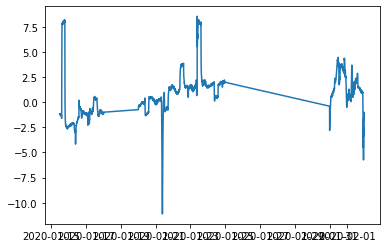

In [376]:
plt.plot(df_downsampled[MEAS_COLUMNS[0]])

In [377]:
TARGETS

['Carbon dioxide CO2',
 '2-Amino-2-methylpropanol C4H11NO',
 'Piperazine C4H10N2',
 'Ammonia NH3']

In [378]:
granger_results = {}

for target in TARGETS:
    results = {}
    for feat in MEAS_COLUMNS:
        results[feat] = check_granger_causality(df_downsampled[feat], df_downsampled[target])
    granger_results[target] = results

### So, what we need to do now, is to have again the three blocks, peform the shift manually 

In [379]:
first_block = [15,16,17]
second_block = [20,21,22,23,24]
third_block = [31,1]

In [380]:
def get_df_for_block(df, days): 
    good_rows = []
    for i in range(len(df)):
        if df.index[i].day in days:
            good_rows.append(df.iloc[i])
    return pd.DataFrame(good_rows)

In [381]:
MEAS_COLUMNS_new = set()

In [382]:
def shift_data(target):
    df_first_block = get_df_for_block(df_downsampled, first_block)
    df_second_block = get_df_for_block(df_downsampled, second_block)
    df_third_block = get_df_for_block(df_downsampled, third_block)
    for i, feat in enumerate(MEAS_COLUMNS):
        shift = granger_results[target][feat]['lag_w_min_p_value']
        df_first_block[feat + '_shift'] = df_first_block[feat].shift(shift).values
        df_second_block[feat + '_shift'] = df_second_block[feat].shift(shift).values
        df_third_block[feat + '_shift'] = df_third_block[feat].shift(shift).values
        
        MEAS_COLUMNS_new.add(feat + '_shift')
        
    df_first_block.dropna(inplace=True)
    df_second_block.dropna(inplace=True)
    df_third_block.dropna(inplace=True)
    longest_df = pd.concat([df_first_block, df_second_block, df_third_block])
    
    return longest_df

In [383]:
def train_model(target, model_param = {'n_estimators': 500,
    'max_depth': 20,
    'colsample_bytree': 0.8,
    'subsample': 0.8}):
    df = shift_data(target)
    
    mc =  list(MEAS_COLUMNS_new) + MEAS_COLUMNS
    
    X = df[mc]
    y = df[TARGETS]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y[target].values.reshape(-1,1), train_size=0.9)
    
    x_scaler = StandardScaler()

    X_train = x_scaler.fit_transform(X_train)
    X_test = x_scaler.transform(X_test)

#     y_train = y_scaler.fit_transform(y_train)
#     y_test = y_scaler.transform(y_test)
    
    xgb = XGBRegressor(**model_param)
    
    xgb.fit(X_train, y_train)
    
    return {
        'model': xgb,
        'train_data': (X_train, y_train),
        'test_data': (X_test, y_test)
    }
    

In [384]:
xgb_results = {}

for target in TARGETS:
    xgb_results[target] = train_model(target)

In [385]:
import numpy as np

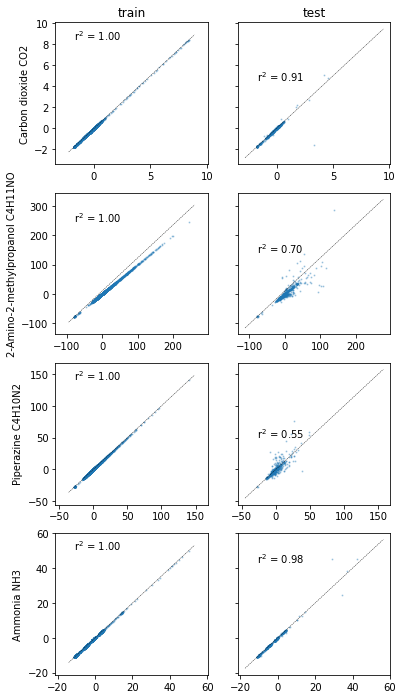

In [386]:
fig, ax = plt.subplots(4,2, sharey='row', sharex='row', figsize=(6,12))
        
counter = 0 
for target, target_results in xgb_results.items():
    train_predict = target_results['model'].predict(target_results["train_data"][0])
    test_predict = target_results['model'].predict(target_results["test_data"][0])
    ax[counter][0].scatter(train_predict, 
                           target_results["train_data"][1].flatten(), alpha=.3,  s=1) 
    ax[counter][1].scatter(test_predict, 
                           target_results["test_data"][1].flatten(), alpha=.3,  s=1)
    
    r2_train = r2_score(train_predict, target_results["train_data"][1].flatten())
    r2_test = r2_score(test_predict, target_results["test_data"][1].flatten())
    ax[counter][0].text(np.min(train_predict), np.max(train_predict), f"r$^2$ = {r2_train:.2f}")
    ax[counter][1].text(np.min(test_predict), np.max(test_predict), f"r$^2$ = {r2_test:.2f}")
    counter += 1
    
for i in range(4):
    ax[i][0].set_ylabel(TARGETS[i])
    for j in range(2):
        a = ax[i][j]
        x_lims = a.get_xlim()
        y_lims = a.get_ylim()
        a.plot(x_lims, y_lims, '--k', lw=.4)
    
ax[0][0].set_title('train')
ax[0][1].set_title('test')

fig.savefig('xgb_model.pdf', bbox_inches='tight')

In [387]:
len(target_results["train_data"][1].flatten())

6112

In [388]:
len(target_results["train_data"][0])

6112

ValueError: x and y must be the same size

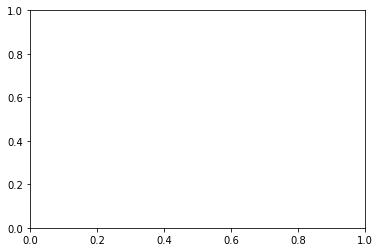

In [389]:
plt.scatter(target_results["train_data"][0], target_results["train_data"][1].flatten(), alpha=.3,  s=1)

In [390]:
baseline = np.mean(xgb_results["2-Amino-2-methylpropanol C4H11NO"]["train_data"][0], axis=0)

In [391]:
grid = np.linspace(-1,1,121)

In [392]:
def run_model(feature_changes, baseline=baseline, xgb_results=xgb_results):
    new_array = deepcopy(baseline)
    predictions = {}
    for k, v in feature_changes.items():
        index = np.where(np.array(MEAS_COLUMNS)==k)[0][0]
        new_array[index] = v
        
    for k, v in xgb_results.items():
        predictions[k] = v['model'].predict(new_array.reshape(1,-1))

    return predictions

In [393]:
results_xgb_analysis = defaultdict(dict)

In [394]:
for ti19 in grid: 
    for fi2 in grid: 
        results_xgb_analysis[ti19][fi2] = run_model({'TI-19': ti19, 'FI-2': fi2})
        

In [395]:
def get_image(target):
    image = np.zeros((len(grid), len(grid)))

    for i, ti19 in enumerate(grid): 
        for j, fi2 in enumerate(grid):
            image[i][j] = results_xgb_analysis[ti19][fi2][target] - results_xgb_analysis[0][0][target]
            
    return image

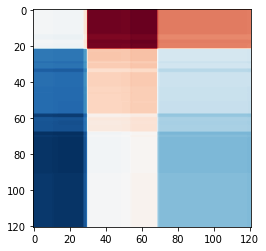

In [396]:
plt.imshow(get_image(TARGETS[0]), cmap='RdBu')

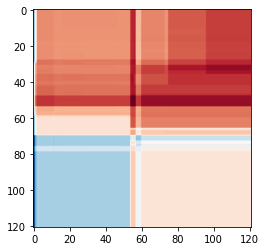

In [397]:
plt.imshow(get_image(TARGETS[1]), cmap='RdBu')

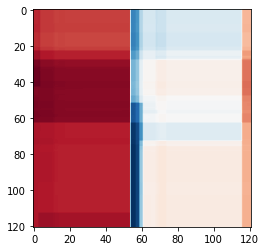

In [398]:
plt.imshow(get_image(TARGETS[2]), cmap='RdBu')

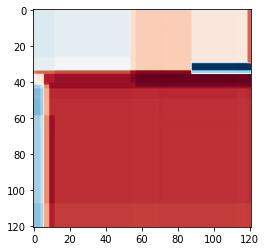

In [399]:
plt.imshow(get_image(TARGETS[3]), cmap='RdBu')

## SHAP 

In [400]:
shap_amp = shap.TreeExplainer(xgb_results[TARGETS[1]]['model'])

In [401]:
shap_amp_value = shap_amp(xgb_results[TARGETS[1]]['train_data'][0], check_additivity=False)

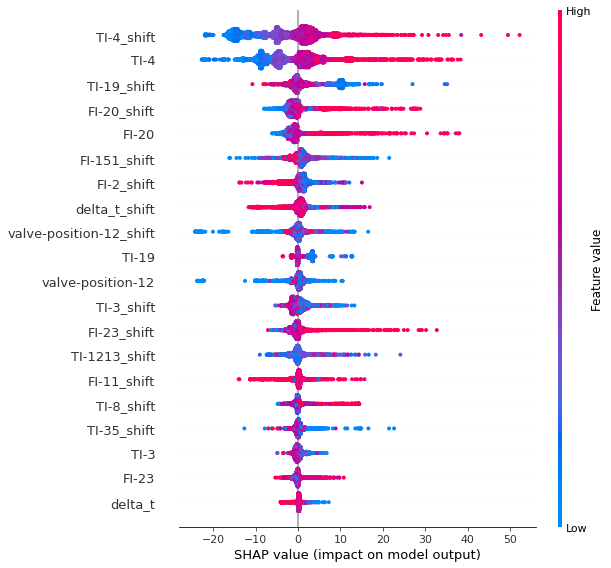

In [402]:
shap.summary_plot(shap_amp_value, feature_names=list(MEAS_COLUMNS_new) + MEAS_COLUMNS)